In [ ]:
# set tf 1.x for colab
%tensorflow_version 1.x

# Intro to TensorFlow

This notebook covers the basics of TF and shows you an animation with gradient descent trajectory.
<img src="images/gradient_descent.png" style="width:50%">

# TensorBoard

**Plase note that if you are running on the Coursera platform, you won't be able to access the tensorboard instance due to the network setup there.**

Run `tensorboard --logdir=./tensorboard_logs --port=7007` in bash.

If you run the notebook locally, you should be able to access TensorBoard on http://127.0.0.1:7007/

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

import sys
sys.path.append("../..")
from keras_utils import reset_tf_session
s = reset_tf_session()
print("We're using TF", tf.__version__)

Using TensorFlow backend.


We're using TF 2.1.0


# Warming up
For starters, let's implement a python function that computes the sum of squares of numbers from 0 to N-1.

In [2]:
import numpy as np

def sum_python(N):
    return np.sum(np.arange(N)**2)

In [3]:
%%time
sum_python(10**5)

Wall time: 0 ns


216474736

# Tensoflow teaser

Doing the very same thing

In [4]:
# An integer parameter
N = tf.placeholder('int64', name="input_to_your_function")

# A recipe on how to produce the same result
result = tf.reduce_sum(tf.range(N)**2)

In [5]:
# just a graph definition
result

<tf.Tensor 'Sum:0' shape=() dtype=int64>

In [6]:
%%time
# actually executing
result.eval({N: 10**5})

Wall time: 24.1 ms


333328333350000

In [7]:
# logger for tensorboard
writer = tf.summary.FileWriter("tensorboard_logs", graph=s.graph)

# How does it work?
1. Define placeholders where you'll send inputs
2. Make a symbolic graph: a recipe for mathematical transformation of those placeholders
3. Compute outputs of your graph with particular values for each placeholder
  * `output.eval({placeholder: value})`
  * `s.run(output, {placeholder: value})`

So far there are two main entities: "placeholder" and "transformation" (operation output)
* Both can be numbers, vectors, matrices, tensors, etc.
* Both can be int32/64, floats, booleans (uint8) of various size.

* You can define new transformations as an arbitrary operation on placeholders and other transformations
 * `tf.reduce_sum(tf.arange(N)**2)` are 3 sequential transformations of placeholder `N`
 * There's a tensorflow symbolic version for every numpy function
   * `a+b, a/b, a**b, ...` behave just like in numpy
   * `np.mean` -> `tf.reduce_mean`
   * `np.arange` -> `tf.range`
   * `np.cumsum` -> `tf.cumsum`
   * If you can't find the operation you need, see the [docs](https://www.tensorflow.org/versions/r1.3/api_docs/python).
   
`tf.contrib` has many high-level features, may be worth a look.

In [8]:
with tf.name_scope("Placeholders_examples"):
    # Default placeholder that can be arbitrary float32
    # scalar, vertor, matrix, etc.
    arbitrary_input = tf.placeholder('float32')

    # Input vector of arbitrary length
    input_vector = tf.placeholder('float32', shape=(None,))

    # Input vector that _must_ have 10 elements and integer type
    fixed_vector = tf.placeholder('int32', shape=(10,))

    # Matrix of arbitrary n_rows and 15 columns
    # (e.g. a minibatch of your data table)
    input_matrix = tf.placeholder('float32', shape=(None, 15))
    
    # You can generally use None whenever you don't need a specific shape
    input1 = tf.placeholder('float64', shape=(None, 100, None))
    input2 = tf.placeholder('int32', shape=(None, None, 3, 224, 224))

    # elementwise multiplication
    double_the_vector = input_vector*2

    # elementwise cosine
    elementwise_cosine = tf.cos(input_vector)

    # difference between squared vector and vector itself plus one
    vector_squares = input_vector**2 - input_vector + 1

In [9]:
my_vector =  tf.placeholder('float32', shape=(None,), name="VECTOR_1")
my_vector2 = tf.placeholder('float32', shape=(None,))
my_transformation = my_vector * my_vector2 / (tf.sin(my_vector) + 1)

In [10]:
print(my_transformation)

Tensor("truediv:0", shape=(None,), dtype=float32)


In [11]:
dummy = np.arange(5).astype('float32')
print(dummy)
my_transformation.eval({my_vector: dummy, my_vector2: dummy[::-1]})

[0. 1. 2. 3. 4.]


array([0.       , 1.6291324, 2.0950115, 2.6289961, 0.       ],
      dtype=float32)

In [12]:
writer.add_graph(my_transformation.graph)
writer.flush()

TensorBoard allows writing scalars, images, audio, histogram. You can read more on tensorboard usage [here](https://www.tensorflow.org/get_started/graph_viz).

# Summary
* Tensorflow is based on computation graphs
* A graph consists of placeholders and transformations

# Loss function: Mean Squared Error

Loss function must be a part of the graph as well, so that we can do backpropagation.

In [13]:
with tf.name_scope("MSE"):
    y_true = tf.placeholder("float32", shape=(None,), name="y_true")
    y_predicted = tf.placeholder("float32", shape=(None,), name="y_predicted")
    # Implement MSE(y_true, y_predicted), use tf.reduce_mean(...)
    mse = tf.reduce_mean((y_true - y_predicted) ** 2)

def compute_mse(vector1, vector2):
    return mse.eval({y_true: vector1, y_predicted: vector2})

In [14]:
writer.add_graph(mse.graph)
writer.flush()

In [15]:
# Rigorous local testing of MSE implementation
import sklearn.metrics
for n in [1, 5, 10, 10**3]:
    elems = [np.arange(n), np.arange(n, 0, -1), np.zeros(n),
             np.ones(n), np.random.random(n), np.random.randint(100, size=n)]
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(sklearn.metrics.mean_squared_error(el, el_2))
            my_mse = compute_mse(el, el_2)
            if not np.allclose(true_mse, my_mse):
                print('mse(%s,%s)' % (el, el_2))
                print("should be: %f, but your function returned %f" % (true_mse, my_mse))
                raise ValueError('Wrong result')

# Variables

Placeholder and transformation values are not stored in the graph once the execution is finished. This isn't too comfortable if you want your model to have parameters (e.g. network weights) that are always present, but can change their value over time.

Tensorflow solves this with `tf.Variable` objects.
* You can assign variable a value at any time in your graph
* Unlike placeholders, there's no need to explicitly pass values to variables when `s.run(...)`-ing
* You can use variables the same way you use transformations 
 

In [16]:
# Creating a shared variable
shared_vector_1 = tf.Variable(initial_value=np.ones(5),
                              name="example_variable")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [17]:
# Initialize variable(s) with initial values
s.run(tf.global_variables_initializer())

# Evaluating the shared variable
print("Initial value", s.run(shared_vector_1))

Initial value [1. 1. 1. 1. 1.]


In [18]:
# Setting a new value
s.run(shared_vector_1.assign(np.arange(5)))

# Getting that new value
print("New value", s.run(shared_vector_1))

New value [0. 1. 2. 3. 4.]


# tf.gradients - why graphs matter
* Tensorflow can compute derivatives and gradients automatically using the computation graph
* True to its name it can manage matrix derivatives
* Gradients are computed as a product of elementary derivatives via the chain rule:

$$ {\partial f(g(x)) \over \partial x} = {\partial f(g(x)) \over \partial g(x)}\cdot {\partial g(x) \over \partial x} $$

It can get you the derivative of any graph as long as it knows how to differentiate elementary operations

In [19]:
my_scalar = tf.placeholder('float32')

scalar_squared = my_scalar**2

# A derivative of scalar_squared by my_scalar
derivative = tf.gradients(scalar_squared, [my_scalar, ])

In [20]:
derivative

[<tf.Tensor 'gradients/pow_1_grad/Reshape:0' shape=<unknown> dtype=float32>]

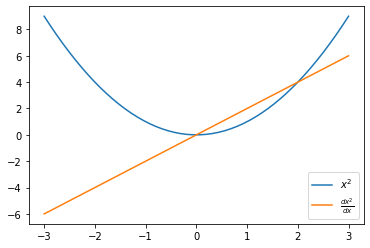

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-3, 3)
x_squared, x_squared_der = s.run([scalar_squared, derivative[0]],
                                 {my_scalar:x})

plt.plot(x, x_squared,label="$x^2$")
plt.plot(x, x_squared_der, label=r"$\frac{dx^2}{dx}$")
plt.legend();

# Why that rocks

In [22]:
my_vector = tf.placeholder('float32', [None])
# Compute the gradient of the next weird function over my_scalar and my_vector
# Warning! Trying to understand the meaning of that function may result in permanent brain damage
weird_psychotic_function = tf.reduce_mean(
    (my_vector+my_scalar)**(1+tf.nn.moments(my_vector,[0])[1]) + 
    1./ tf.atan(my_scalar))/(my_scalar**2 + 1) + 0.01*tf.sin(
    2*my_scalar**1.5)*(tf.reduce_sum(my_vector)* my_scalar**2
                      )*tf.exp((my_scalar-4)**2)/(
    1+tf.exp((my_scalar-4)**2))*(1.-(tf.exp(-(my_scalar-4)**2)
                                    )/(1+tf.exp(-(my_scalar-4)**2)))**2

der_by_scalar = tf.gradients(weird_psychotic_function, my_scalar)
der_by_vector = tf.gradients(weird_psychotic_function, my_vector)

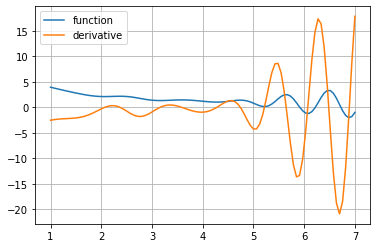

In [23]:
# Plotting the derivative
scalar_space = np.linspace(1, 7, 100)

y = [s.run(weird_psychotic_function, {my_scalar:x, my_vector:[1, 2, 3]})
     for x in scalar_space]

plt.plot(scalar_space, y, label='function')

y_der_by_scalar = [s.run(der_by_scalar,
                         {my_scalar:x, my_vector:[1, 2, 3]})
                   for x in scalar_space]

plt.plot(scalar_space, y_der_by_scalar, label='derivative')
plt.grid()
plt.legend();

# Almost done - optimizers

While you can perform gradient descent by hand with automatic gradients from above, tensorflow also has some optimization methods implemented for you. Recall momentum & rmsprop?

In [24]:
y_guess = tf.Variable(np.zeros(2, dtype='float32'))
y_true = tf.range(1, 3, dtype='float32')

loss = tf.reduce_mean((y_guess - y_true + 0.5*tf.random_normal([2]))**2) 

step = tf.train.MomentumOptimizer(0.03, 0.5).minimize(loss, var_list=y_guess)

Let's draw a trajectory of a gradient descent in 2D

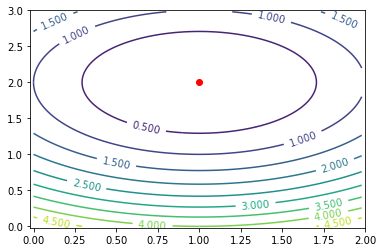

In [28]:
from matplotlib import animation, rc
import matplotlib_utils
from IPython.display import HTML, display_html

# nice figure settings
fig, ax = plt.subplots()
y_true_value = s.run(y_true)
level_x = np.arange(0, 2, 0.02)
level_y = np.arange(0, 3, 0.02)
X, Y = np.meshgrid(level_x, level_y)
Z = (X - y_true_value[0])**2 + (Y - y_true_value[1])**2
ax.set_xlim(-0.02, 2)
ax.set_ylim(-0.02, 3)
s.run(tf.global_variables_initializer())
ax.scatter(*s.run(y_true), c='red')
contour = ax.contour(X, Y, Z, 10)
ax.clabel(contour, inline=1, fontsize=10)
line, = ax.plot([], [], lw=2)

# start animation with empty trajectory
def init():
    line.set_data([], [])
    return (line,)

trajectory = [s.run(y_guess)]

# one animation step (make one GD step)
def animate(i):
    s.run(step)
    trajectory.append(s.run(y_guess))
    line.set_data(*zip(*trajectory))
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

In [26]:
try:
    display_html(HTML(anim.to_html5_video()))
except (RuntimeError, KeyError):
    # In case the build-in renderers are unaviable, fall back to
    # a custom one, that doesn't require external libraries
    anim.save(None, writer=matplotlib_utils.SimpleMovieWriter(0.001))

<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAABNBm1kYXQAAAKgBgX//5zcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTYwIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv
cHlsZWZ0IDIwMDMtMjAyMCAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w
dGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o
ZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2
IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0
X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTYgbG9va2FoZWFkX3RocmVhZHM9
MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2Nv
bXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9
MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50
PTI1MCBrZXlpbnRfbWluPTI1IHNjZW5lY3V0PTQwIGludHJhX3JlZnJlc2g9MCByY19sb29rYWhl
YWQ9NDAgcmM9Y3JmIG1idHJlZT0xIGNyZj0yMy4wIHFjb21wPTAuNjAgcXBtaW49MCBxcG1heD02
OSBxcHN0ZXA9NCBpcF9yYXRpbz0xLjQwIGFxPTE6MS4wMACAAAAynGWIhAAv//72rvzLK0cLlS4d
WXuzUfLoSXL9iDB9aAAAAwAA1WshfKGCVVAY4OQpfFAvedMJ0Dm5sS6TEnk3difoO7J6M7UHMoQC
7SDcOVGjTItyhp18FcAAFYwPa7PtpoPe/Zp+iT+SjpnwgpLMZBFpwalYsUpWrMy7YhF3ikv6SSso
GWurELpGeNLCX5uVpAt9W/yLRiK06vqHZzwQ1E82y9rnZNvAyNek4Lpwzr8ud5k6hMNb/zYynk9Y
KphfQMtIxexB0gujNY6iYWhgPtiO7IlN7W4c5vve5IYoacOOxWc3/0r97oP4xn4lPfXJop+Kzzx/
6jUbZTbw8Qh2hGXxiSrM9hYLN89zpIniVwUZvm0Q12TETt7D+0fR+JaGJD06667FcEODokDAFA/i
8/rugVfifDKumAcys/jnjlqPg+YVtzVV1ONYUR8sZ6AKXArQaa/cAUQmi9ctHxPinhcMaJpDKjjW
TN56u+DAilp3QQ14lKSuh74a6PLMM8p75D4AVacVqEtRgtRInzYjvf3KxqErTyIZrnxE2+nEHMTQ
5P0/83qSK+/1MCJFmRmLiExHNTyW/+oaSZf2Vvzf1XhBfl9k1wl/l8tieRzokvwXn5DB6E/UUxRw
4vdRm5lIr9xdO0KbjyUQpCSc/8E6FRriknLVn+n+/TzewiF7xntks+U3luvECJe1d7FQOKi1HIVw
5rMeYCrMEqJkxNuuIb1/NhwwYq7S4PxXLPWbWGuCetbm9e5und1S1E65DbS5JFqylKjLdpt1LyOq
9mAk7ZFcnc2UFMLiu0Om2VHWOrGBSSkP+JBletVcldcDLeBAi+1Y/RLA1kFo+1ziURPkUABGqnOC
oGuXTE6hHIyj66vZSTS0fvzv6QblFhk/O5+FzSeWp0z8smXx8ZDb5kJhA0rS0j/zMVuaUtv2wJBI
GcwfkA6D1y4MvvrrwzhV40ViDN2UXg9Uegk/dL7+E572BBMWXbiptfib1H628cGHAKwvnxWXnNxE
J1KfkcAOHijGOy0G/VZx973FcuK6/7UxBMTrJb6NtTO4CR0kQRB3Na4aLGoEq0p6mIcwA65CopYq
1BlnO8N3/bLmuCUxD8omAA7IPr2yMAvRjUMOmfSVAqZkOWEzSWZ9LvxlwgPp1ejHbo3bCW+l7+S0
xIBMLkj930EE64TZBn3Dk7eSr7qsaoQyAFUAu4F2863+zctWJxoFoQ5GkIkMypGB50AL5z44Q4Xq
2eF9rpi/M0+8j8NV7LQKjLCn+IZ/bkRGK7lTfxnf8g5YibpcxBiqhPtwrGrl2IlLg36DgfqxjxLI
XDGXLIQA6uq2VVO3q1O6g0Zl3yBQvjyZIz4wBCZwrElBBYu5e8t8BZS0XR/MdiFiRKOh4IhfJ1AW
3vjXpcLa0Y6eKZt/gH/bPpusFm7yTbWu3YIWE4uF9GRGO9DkUTGtxKgmH+Ar9hUqDFPpX7Nl79iZ
Sz7FWNij/M18Taezm5E3cds8RmTiiSSJZ1N5Dq0x9ChbVUxOfbLVyhFVWjU3HtoPFPNkjLi4qd/E
c/0TfJioCuuDYllilBwrox9BFXxwp97LthnGbznzNUAm98pmdlMFc7KvbbNpoHudCdz+qxor3Iy/
5PZfEy94HQTSdOpF0VT3te/afbxTZETpHyBL8PAuRZY6Mq9niQoUiI0XRSFqFZbbbWU/1P4BpyOX
cGXjpc2JlJFYhFNW9NOUJ/k8yV63rF2ppBMi1k5d9DqFwdmHFl71HrqpZCfRMHr+9B2fVB8z2U0a
lksihGVEwp9AXU3jtPw9IlZxlCahQW2JOUshzlkkICWRjHRoA4KFN7bttOGdA2P5cFEgCMUxMdsb
bmypNnTf9ZipA9aJLVqgGtqLqMhCNIUZ/cAUwyAK21iMqIERaPsPqbkvVRrf7rorW6mlL6wpxyks
AKmgCiqvb6gwYOY8VtFqIUvZ588SQrjPXtysFTKfJZAMGGx9pZpZ9pLmtlVJXohpWdwB+5aCZzuq
l/NLNeDXSjFtu0ROqEzXBLSnlPkAhEitYcXtTOgw2jGBHndZARd7sRKXMUwLjkbAWxeWn/uhxogU
JRPN9usCosvo2vf+ukz7xY/VCDx/xfhWdl+JDrWCy3trxHeSEZ/h0AzjBanKnfiogFsWTcdWcm2s
Efc5H3MomrUoMSYnbVAU1HYjHc8YgHzyr3VE6wB9VMiCxi6X9KGKamiIZxHqxel/Fcd0kFFBnZ/v
ADA6G7sM0d9lM1dZ3Amk2ny+Ti0e8VStSmkM9ajnyULiNRdfoLEaA58J3VzxFjhxJQoLWDtNM1Aj
49I/78qpGMLWJ111Xi6I3L9kvMrrfizhzipk8CLqzvqeLbtxx6YgA30z1dSGEFr9HMpmkNMzRG2J
CvjYOuHwjahOAwOExbxnWbm/BZ3fjnzsA7AUUfjywRT16ls2ROqOF9g06MnKbegTNfpFN2oYmWjE
VJ9MLoMFQhNI9A8aGckAxGnPQUcCDlCDLcf8VPBd2lobtCHchZXi5v5WW4Zde8a1jHvgvi/qhzVx
zWZmtYhrDrFgVyohi/vKkjkI0YsDCmcQhAaGlr8rAJSZpEJHRZnJiWG2+vQG7mc/9YJ0blRqScki
JQijSGQK12Oahy+jUWnhEfkPIecHZrODXiaZM7ve5ct6bpU3I6pDH2Liipvmm6CSVLD+69CwAHks
/IZPVLqws2g4XCRfmF4GjfBiKf8nBBfFc55aKy9ZAWvT1+AfoPBHlzwUgsPEu/AeD0LqJ/qwjQM+
SNJYGxOgIvMxH9obrpcRi9Vc9Av795LdPnKSgho4Y/aEqLJh+ZUdA1XJnSNY/+DgkdR+YwqJ1aDc
wlm6ci1xpIEqyjbcToxBRJb7bd5HQl8WfNOfVKCJUYgTN9ZwOoteF0uvq9TOu0hHNfjWHqLDobK5
t5SyYMYQJY6HeioKHN9/C